In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.patches as patches
import re

# CENG0013: Process Design Principle's Pinch Method

In [2]:
def load_data(file_path):
    """Load data from an Excel file and adjust the DataFrame index."""
    data = pd.read_excel(file_path)
    data.index = data.index + 1  # Shift index to start from 1
    return data

In [3]:
def calculate_duty_and_flux(dataframe):
    """Calculate duty and flux for each stream and add as new columns to the DataFrame."""
    duties = []
    fluxes = []
    for i in range(1, len(dataframe) + 1):
        duty_kj_hr = dataframe['Cp (kJ/kmol/K)'][i] * dataframe['T_diff'][i] * dataframe['Molar Flow Rate [kmol/hr]'][i]
        duty_kw = duty_kj_hr / 3600  # Convert to kW
        flux_kw_k = duty_kw / dataframe['T_diff'][i]

        duties.append(duty_kw)
        fluxes.append(flux_kw_k)

    dataframe['Duty [kW]'] = duties
    dataframe['Flux [kW / K]'] = fluxes
    return dataframe

In [4]:
# Load the stream data
stream_data = load_data('streams/AEStreamTable2.xlsx')

# Calculate duty and flux and update the DataFrame
updated_stream_data = calculate_duty_and_flux(stream_data)

updated_stream_data

,Stream Number,Type,Molar Flow Rate [kmol/hr],Tin,Tout,T_diff,Cp (kJ/kmol/K),Duty [kW],Flux [kW / K]
1,S2,cold,162.598652,93.790304,150.000000,-56.209696,175.453272,-445.437877,7.924574
2,S9,cold,309.317662,124.850263,619.999892,-495.149629,226.374457,-9630.882812,19.450449
3,S11,cold,256.000000,20.000000,620.000000,-600.000000,29.584853,-1262.287059,2.103812
4,S12,hot,575.347324,620.000000,2.000000,618.000000,124.000000,12247.226712,19.817519
5,S15,cold,158.352029,0.547123,150.000000,-149.452877,150.560459,-989.774681,6.622654
6,S21,cold,500.000000,20.000000,150.000000,-130.000000,29.089416,-525.225564,4.040197
7,S22,hot,337.018246,150.000000,25.000000,125.000000,139.855395,1636.590970,13.092728
8,S24,hot,322.000000,25.000000,23.100976,1.899024,149.396949,25.376144,13.362727
9,S25,cold,7.497616,24.999994,150.000000,-125.000006,29.392114,-7.651764,0.061214
10,S27,cold,215.715500,20.000000,100.000000,-80.000000,199.685133,-957.226184,11.965327


# Set the minimum driving force $\Delta T_{min}$ and construct the temperature interval table

In [5]:
def constructTemperatureInterval(df, Tmin):
    """
    Constructs temperature intervals from stream data in a DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing stream data.
    Tmin (float): Minimum temperature difference.

    Returns:
    DataFrame: DataFrame containing temperature intervals.
    """
    temperatures = []
    for index, row in df.iterrows():
        temperatures.append((row['Tin'], row['Type'], 'supply', row['Stream Number']))
        temperatures.append((row['Tout'], row['Type'], 'target', row['Stream Number']))

    temperatures.sort(reverse=True, key=lambda x: x[0])

    interval_data = []
    for temp, stream_type, temp_type, stream_number in temperatures:
        t_high = temp + Tmin if stream_type.lower() == 'cold' else temp
        t_low = temp if stream_type.lower() == 'cold' else max(temp - Tmin, 0)
        interval_data.append({'t1': max(t_high, t_low), 't2': min(t_high, t_low), 
                              'streamNumbers_hot': [], 'streamNumbers_cold': []})

    intervals_df = pd.DataFrame(interval_data)
    intervals_df.sort_values(by='t1', ascending=False, inplace=True)

    # Assign streams to intervals
    for index, interval in intervals_df.iterrows():
        for idx, row in df.iterrows():
            if row['Type'].lower() == 'hot' and row['Tin'] >= interval['t1'] and row['Tout'] <= interval['t1']:
                interval['streamNumbers_hot'].append(row['Stream Number'])
            elif row['Type'].lower() == 'cold' and row['Tin'] <= interval['t2'] and row['Tout'] >= interval['t2']:
                interval['streamNumbers_cold'].append(row['Stream Number'])

    # Convert lists to strings to remove duplicates
    intervals_df['streamNumbers_hot'] = intervals_df['streamNumbers_hot'].apply(lambda x: ','.join(map(str, x)))
    intervals_df['streamNumbers_cold'] = intervals_df['streamNumbers_cold'].apply(lambda x: ','.join(map(str, x)))

    # Remove duplicate intervals
    intervals_df = intervals_df.drop_duplicates(subset=['t1', 't2', 'streamNumbers_cold', 'streamNumbers_hot'])

    # Convert strings back to lists if needed
    intervals_df['streamNumbers_hot'] = intervals_df['streamNumbers_hot'].apply(lambda x: x.split(',') if x else [])
    intervals_df['streamNumbers_cold'] = intervals_df['streamNumbers_cold'].apply(lambda x: x.split(',') if x else [])
    
    return intervals_df

# $\Delta T_{min}$ chosen as 15°C

In [6]:
Temp_intervals = constructTemperatureInterval(updated_stream_data, 15)
Temp_intervals.reset_index(drop=True)

,t1,t2,streamNumbers_hot,streamNumbers_cold
0,635.000000,620.000000,[],[S11]
1,634.999892,619.999892,[],"[S9, S11]"
2,620.000000,605.000000,[S12],"[S9, S11]"
3,165.000000,150.000000,[S12],"[S2, S9, S11, S15, S21, S25]"
4,150.000000,135.000000,"[S12, S22]","[S2, S9, S11, S15, S21, S25]"
5,139.850263,124.850263,"[S12, S22]","[S2, S9, S11, S15, S21, S25]"
6,115.000000,100.000000,"[S12, S22]","[S2, S11, S15, S21, S25, S27]"
7,111.018129,96.018129,"[S12, S22]","[S2, S11, S15, S21, S25, S27, S28]"
8,108.790304,93.790304,"[S12, S22]","[S2, S11, S15, S21, S25, S27, S28]"
9,96.189753,81.189753,"[S12, S22, S37]","[S11, S15, S21, S25, S27, S28]"


# Draw the temperature interval diagram

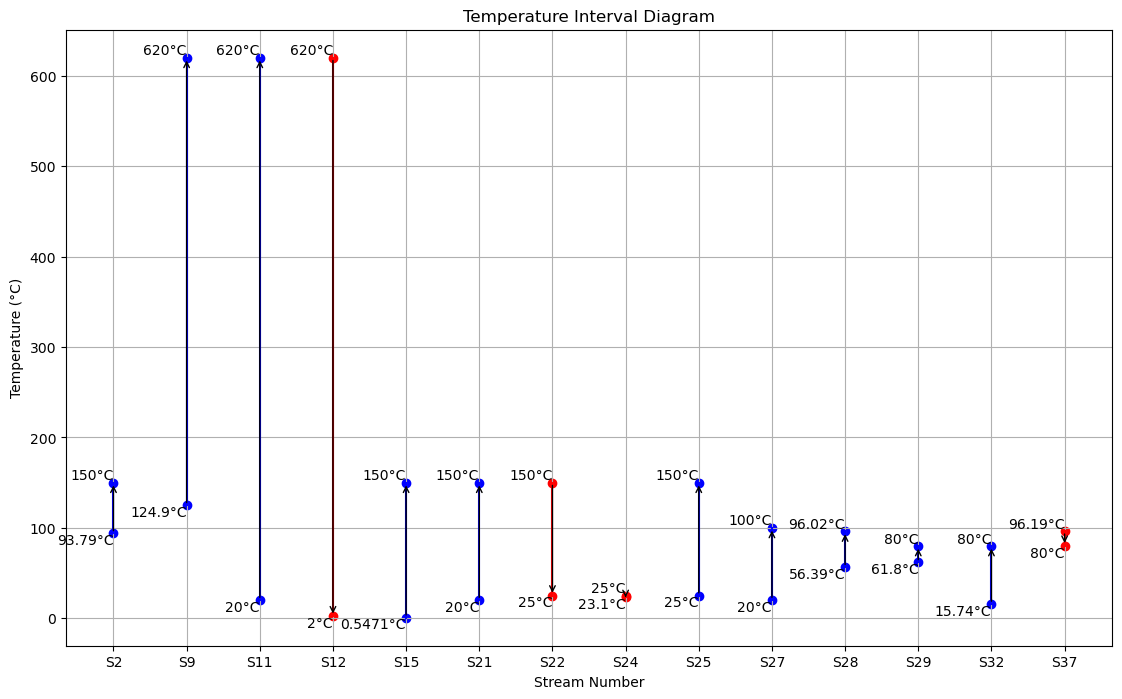

In [7]:
def draw_temperature_interval_diagram(intervals_df):
    """
    Draws a temperature interval diagram for Pinch Analysis with temperature on the y-axis
    and stream numbers on the x-axis. Differentiates between hot and cold streams with
    different colors and arrow directions. Annotates the starting and end temperatures for each stream.

    Parameters:
    intervals_df (DataFrame): DataFrame containing temperature intervals and stream numbers.
    """
    
    # Sort streams numerically based on the number after the 'S'
    def extract_number(s):
        return int(re.search(r'\d+', s).group())

    
    plt.figure(figsize=(13.5, 8))

    # Create a dictionary to store the highest and lowest temperature for each stream
    stream_temp_ranges = {}

    # Update the temperature range for each stream
    for index, row in intervals_df.iterrows():
        for stream in row['streamNumbers_cold']:
            if stream not in stream_temp_ranges:
                stream_temp_ranges[stream] = {'min': row['t2'], 'max': row['t2'], 'type': 'cold'}
            else:
                stream_temp_ranges[stream]['min'] = min(stream_temp_ranges[stream]['min'], row['t2'])
                stream_temp_ranges[stream]['max'] = max(stream_temp_ranges[stream]['max'], row['t2'])

        for stream in row['streamNumbers_hot']:
            if stream not in stream_temp_ranges:
                stream_temp_ranges[stream] = {'min': row['t1'], 'max': row['t1'], 'type': 'hot'}
            else:
                stream_temp_ranges[stream]['min'] = min(stream_temp_ranges[stream]['min'], row['t1'])
                stream_temp_ranges[stream]['max'] = max(stream_temp_ranges[stream]['max'], row['t1'])

    all_streams = sorted(stream_temp_ranges.keys(), key=extract_number)
    stream_positions = {stream: i for i, stream in enumerate(all_streams, start=1)}

    # Plotting the streams
    for stream, temps in stream_temp_ranges.items():
        x_pos = stream_positions[stream]
        color = 'red' if temps['type'] == 'hot' else 'blue'
        plt.plot([x_pos, x_pos], [temps['max'], temps['min']], color=color, label='Hot Stream' if temps['type'] == 'hot' else 'Cold Stream')
        plt.scatter([x_pos, x_pos], [temps['max'], temps['min']], color=color)

        # Annotate the temperatures at the start and end points with four significant figures
        max_temp_formatted = "{:.4g}".format(temps['max'])
        min_temp_formatted = "{:.4g}".format(temps['min'])
        plt.text(x_pos, temps['max'], f'{max_temp_formatted}°C', ha='right', va='bottom')
        plt.text(x_pos, temps['min'], f'{min_temp_formatted}°C', ha='right', va='top')


        # Different arrow styles for hot and cold streams
        if temps['type'] == 'hot':
            plt.annotate('', xy=(x_pos, temps['min']), xytext=(x_pos, temps['max']),
                         arrowprops=dict(facecolor=color, arrowstyle='->'))
        else:
            plt.annotate('', xy=(x_pos, temps['max']), xytext=(x_pos, temps['min']),
                         arrowprops=dict(facecolor=color, arrowstyle='->'))

    plt.ylabel('Temperature (°C)')
    plt.xlabel('Stream Number')
    plt.title('Temperature Interval Diagram')
    #plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(all_streams) + 1), all_streams)
    
#     # Sort intervals_df by t1 and t2 to ensure they are in the correct sequence
#     intervals_df = intervals_df.sort_values(by=['t1', 't2'])

#     # Draw a lightly shaded line for t1 and t2 of each interval
#     for _, row in intervals_df.iterrows():
#         current_t1 = row['t1']
#         current_t2 = row['t2']
#         plt.axhline(y=current_t1, color='grey', linestyle='-', alpha=0.5)  # Light line for current t1
#         plt.axhline(y=current_t2, color='grey', linestyle='-', alpha=0.5)  # Light line for current t2

    plt.show()

draw_temperature_interval_diagram(Temp_intervals)


# Compute net utility usage per interval

In [8]:
def compute_utilities_for_all_intervals(stream_df, interval_df):
    """Compute the utilities for all intervals in the interval DataFrame."""
    
    def parse_stream_data(stream_df):
        """Parse the stream data (flux) from a DataFrame into a dictionary."""
        stream_dict = {}
        for index, row in stream_df.iterrows():
            stream_number = row['Stream Number']
            flux = row['Flux [kW / K]']
            stream_dict[stream_number] = flux
        return stream_dict
    
    streams = parse_stream_data(stream_df)

    utilities_data = []

    for i in range(len(interval_df) - 1):
        hot_utility = 0
        cold_utility = 0

        current_interval = interval_df.iloc[i]
        next_interval = interval_df.iloc[i + 1]

        # Hot
        t1_diff = current_interval['t1'] - next_interval['t1']
        # Cold
        t2_diff = next_interval['t2'] - current_interval['t2']

        current_hot_streams = current_interval['streamNumbers_hot']
        current_cold_streams = current_interval['streamNumbers_cold']
        
        next_hot_streams = next_interval['streamNumbers_hot']
        next_cold_streams = next_interval['streamNumbers_cold']

        for stream in current_hot_streams:
            if stream in streams and stream in next_hot_streams:
                hot_utility += t1_diff * streams[stream]

        for stream in current_cold_streams:
            if stream in streams and stream in next_cold_streams:
                cold_utility += t2_diff * streams[stream]

        net_utility = hot_utility + cold_utility
        status = 'Surplus' if net_utility > 0 else 'Deficit'
        utilities_data.append({
            'Interval': i, 
            'Hot Utility [kW]': hot_utility, 
            'Cold Utility [kW]': cold_utility, 
            'Net Utility [kW]': net_utility,
            'Status': status
        })

    return pd.DataFrame(utilities_data)


In [9]:
stream_data_df = updated_stream_data  
interval_data_df = Temp_intervals  

utilities_df = compute_utilities_for_all_intervals(stream_data_df, interval_data_df)
utilities_df

,Interval,Hot Utility [kW],Cold Utility [kW],Net Utility [kW],Status
0,0,0.000000,-0.000226,-0.000226,Deficit
1,1,0.000000,-323.311600,-323.311600,Deficit
2,2,9016.971123,-9807.188832,-790.217709,Deficit
3,3,297.262784,-603.043494,-305.780710,Deficit
4,4,334.030342,-408.048850,-74.018507,Deficit
5,5,817.828293,-515.703849,302.124443,Surplus
6,6,131.044342,-130.277954,0.766388,Surplus
7,7,73.318271,-86.235360,-12.917088,Deficit
8,8,414.687263,-387.892160,26.795104,Surplus
9,9,44.039941,-36.625046,7.414896,Surplus


# Draw the utility diagram

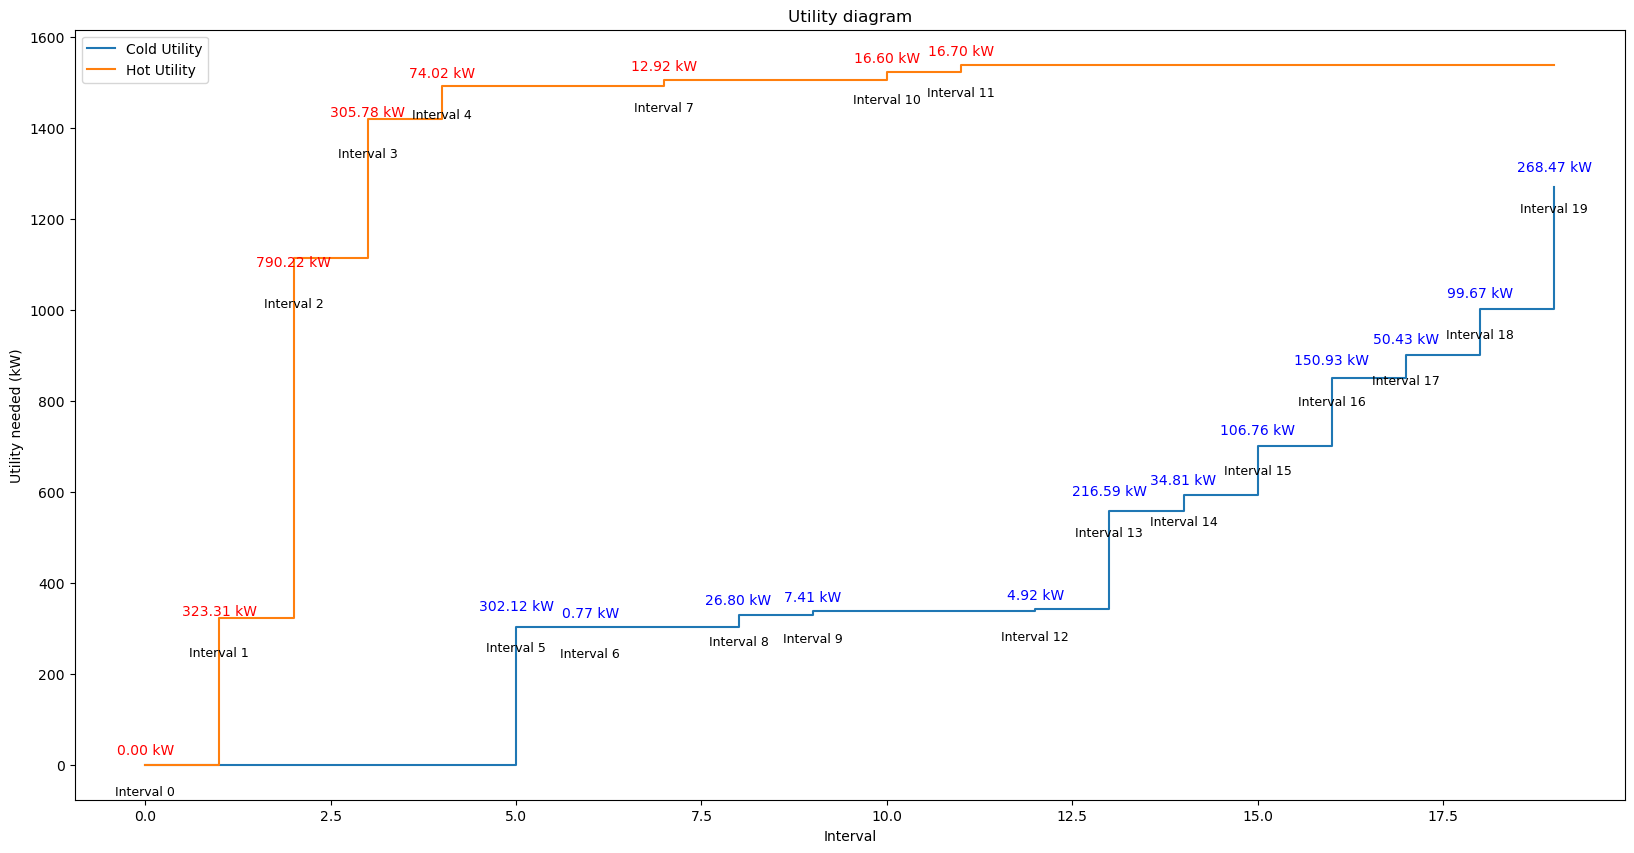

In [10]:
utilities_df.loc[0, 'Cumulative Hot Utility'] = utilities_df.loc[0, 'Hot Utility [kW]']
utilities_df.loc[0, 'Cumulative Cold Utility'] = utilities_df.loc[0, 'Cold Utility [kW]']

for i in range(1, len(utilities_df)):
    net_utility = utilities_df.loc[i, 'Net Utility [kW]']
    status = utilities_df.loc[i, 'Status']
    
    if status == 'Surplus':
        utilities_df.loc[i, 'Cumulative Cold Utility'] = utilities_df.loc[i-1, 'Cumulative Cold Utility'] + net_utility
        utilities_df.loc[i, 'Cumulative Hot Utility'] = utilities_df.loc[i-1, 'Cumulative Hot Utility']
    else: # Deficit
        utilities_df.loc[i, 'Cumulative Hot Utility'] = utilities_df.loc[i-1, 'Cumulative Hot Utility'] - net_utility
        utilities_df.loc[i, 'Cumulative Cold Utility'] = utilities_df.loc[i-1, 'Cumulative Cold Utility']

# Now, plot the cascades using the cumulative values
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the cold utility cascade
ax.step(utilities_df['Interval'], utilities_df['Cumulative Cold Utility'], label='Cold Utility', where='post')


# Plot the hot utility cascade
ax.step(utilities_df['Interval'], utilities_df['Cumulative Hot Utility'], label='Hot Utility', where='post')

# Annotate net utility and interval
for i, row in utilities_df.iterrows():
    # Determine the position for annotation
    y_position = row['Cumulative Hot Utility'] if row['Status'] == 'Deficit' else row['Cumulative Cold Utility']
    y_position += (row['Net Utility [kW]'] * 0.05)  # Slight offset from the utility line
    
    # Determine color based on surplus or deficit
    color = 'blue' if row['Status'] == 'Surplus' else 'red'
    
    # Annotate the net utility value
    ax.annotate(f"{abs(row['Net Utility [kW]']):.2f} kW",
                xy=(row['Interval'], y_position),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom',
                color=color)
    
    # Annotate the interval number
    ax.annotate(f"Interval {i}",
                xy=(row['Interval'], y_position),
                xytext=(0, -15), textcoords='offset points',
                ha='center', va='top',
                color='black', fontsize=9)

# Add labels and title to the plot
ax.set_xlabel('Interval')
ax.set_ylabel('Utility needed (kW)')
ax.set_title('Utility diagram')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

# Find the Minimum Cooling requirement

<img src="./images/Minimum_Cooling_requirement.png" alt="Find the Minimum Cooling requirement">

In [11]:
# Minimum cooling requirements

df6 = utilities_df[utilities_df['Interval'] > 4].copy()
df6

,Interval,Hot Utility [kW],Cold Utility [kW],Net Utility [kW],Status,Cumulative Hot Utility,Cumulative Cold Utility
5,5,817.828293,-515.703849,302.124443,Surplus,1493.328526,302.124217
6,6,131.044342,-130.277954,0.766388,Surplus,1493.328526,302.890605
7,7,73.318271,-86.235360,-12.917088,Deficit,1506.245615,302.890605
8,8,414.687263,-387.892160,26.795104,Surplus,1506.245615,329.685708
9,9,44.039941,-36.625046,7.414896,Surplus,1506.245615,337.100604
10,10,555.240655,-571.844971,-16.604316,Deficit,1522.849931,337.100604
11,11,105.435022,-122.135188,-16.700165,Deficit,1539.550096,337.100604
12,12,177.928389,-173.011058,4.917331,Surplus,1539.550096,342.017935
13,13,1033.046658,-816.454810,216.591848,Surplus,1539.550096,558.609783
14,14,164.551032,-129.744670,34.806363,Surplus,1539.550096,593.416146


In [12]:
df6['Cumulative Utility [kW]'] = df6['Net Utility [kW]'].cumsum()

minimum_cooling_requirement = df6['Cumulative Utility [kW]'][19]

print(f"Minimum cooling requirement: {minimum_cooling_requirement} [kW]")

Minimum cooling requirement: 1223.4643545589552 [kW]


# Procedure for Hot Curve

<img src="./images/Hot.png" alt="Procedure for hot curve">

In [13]:
def prepare_hot_enthalpy_data(dfx, tmp_hot):
    """
    Prepare enthalpy data for hot utility from a DataFrame.
    
    Args:
    df: DataFrame containing hot utility values and temperatures.

    Returns:
    DataFrame with cumulative hot utility values and temperatures.
    """
    # Reverse the order of hot utility and calculate cumulative utility
    reversed_hot_utility = list(reversed(dfx['Hot Utility [kW]'].tolist()))
    reversed_hot_utility.insert(0, 0)  # Add 0 utility at the start
    df_hot = pd.DataFrame({"Cumulative Utility [kW]": reversed_hot_utility, "Temperature": tmp_hot})
    df_hot['Cumulative Utility [kW]'] = df_hot['Cumulative Utility [kW]'].cumsum()
    return df_hot

In [14]:
temperatures_hot = Temp_intervals.copy()['t1'][::-1].reset_index(drop=True)
# print(temperatures_hot)

df_hot = prepare_hot_enthalpy_data(utilities_df, temperatures_hot)
print(df_hot)

    Cumulative Utility [kW]  Temperature
0                  0.000000     2.000000
1                268.470376    15.547123
2                418.168986    23.100976
3                481.179079    25.000000
4                670.137790    30.741638
5                810.281547    35.000000
6                974.832579    39.999994
7               2007.879237    71.389812
8               2185.807626    76.796286
9               2291.242648    80.000000
10              2846.483304    95.000000
11              2890.523245    96.189753
12              3305.210509   108.790304
13              3378.528780   111.018129
14              3509.573122   115.000000
15              4327.401414   139.850263
16              4661.431756   150.000000
17              4958.694541   165.000000
18             13975.665664   620.000000
19             13975.665664   634.999892
20             13975.665664   635.000000


# Procedure for Cold Curve

<img src="./images/Cold.png" alt="Procedure for cold curve">

In [15]:
def prepare_cold_enthalpy_data(dfx, min_cooling_requirement, tmp_cold):
    """
    Prepare enthalpy data for cold utility from a DataFrame.
    
    Args:
    df: DataFrame containing cold utility values and temperatures.
    min_cooling_requirement: Minimum cooling requirement for the 0th interval.

    Returns:
    DataFrame with cumulative cold utility values and temperatures.
    """
    # Reverse the order of cold utility, add minimum cooling requirement at the start
    reversed_cold_utility = list(reversed(dfx['Cold Utility [kW]'].tolist()))
    reversed_cold_utility.insert(0, min_cooling_requirement)
    df_cold = pd.DataFrame({"Cumulative Utility [kW]": reversed_cold_utility, "Temperature": tmp_cold})
    df_cold['Cumulative Utility [kW]'] = df_cold['Cumulative Utility [kW]'].cumsum()
    for i in range(len(df_cold['Cumulative Utility [kW]'])): 
        if df_cold['Cumulative Utility [kW]'][i] < 0: 
            df_cold['Cumulative Utility [kW]'][i] = - df_cold['Cumulative Utility [kW]'][i]
            
            
    return df_cold

In [16]:
temperatures_cold = [i - 10 for i in temperatures_hot]
# print(temperatures_cold)

# Assuming hot_utility_results, cold_utility_results, temperatures_hot, and temperatures_cold are defined
min_cooling_requirement = minimum_cooling_requirement

df_cold = prepare_cold_enthalpy_data(utilities_df, min_cooling_requirement, temperatures_cold)
print(df_cold)


    Cumulative Utility [kW]  Temperature
0               1223.464355    -8.000000
1               1223.464355     5.547123
2               1173.437806    13.100976
3               1160.861225    15.000000
4               1122.836346    20.741638
5               1089.452361    25.000000
6                959.707691    29.999994
7                143.252881    61.389812
8                 29.758177    66.796286
9                151.893365    70.000000
10               723.738336    85.000000
11               760.363382    86.189753
12              1148.255542    98.790304
13              1234.490902   101.018129
14              1364.768856   105.000000
15              1880.472705   129.850263
16              2288.521555   140.000000
17              2891.565049   155.000000
18             12698.753880   610.000000
19             13022.065481   624.999892
20             13022.065707   625.000000


# Plot the Temperature-Enthalpy Diagram


<img src="./images/Temperature_Enthalpy.png" alt="Temperature_Enthalpy">

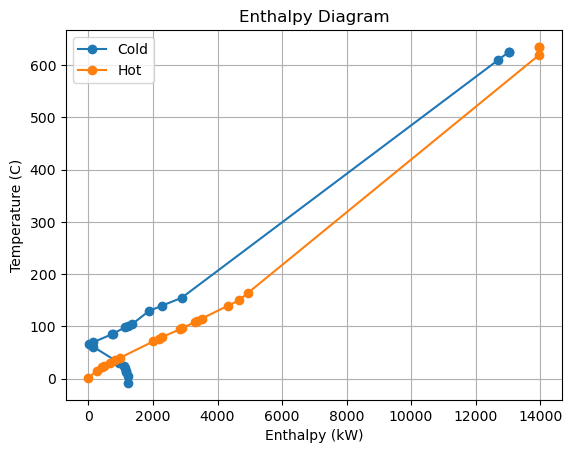

In [17]:
def plot_enthalpy_diagrams(df_hot, df_cold):
    """
    Plot enthalpy diagrams for hot and cold streams.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    """
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-o", label='Cold')
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-o", label='Hot')
    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_enthalpy_diagrams(df_hot, df_cold)

In [18]:
def get_interpolated_temps(df_hot, df_cold):
    interp_hot = interp1d(df_hot['Cumulative Utility [kW]'], df_hot['Temperature'], kind='linear')
    interp_cold = interp1d(df_cold['Cumulative Utility [kW]'], df_cold['Temperature'], kind='linear')
    return interp_hot, interp_cold

def calculate_temperature_diff(interp_hot, interp_cold, cumulative_utility_values):
    return np.abs(interp_cold(cumulative_utility_values) - interp_hot(cumulative_utility_values))

def find_min_temp_diff(temperature_diff, cumulative_utility_values):
    min_temp_diff_index = np.argmin(temperature_diff)
    return temperature_diff[min_temp_diff_index], cumulative_utility_values[min_temp_diff_index]

def plot_temp_diff(cumulative_utility_values, temperature_diff, min_temp_diff, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side):
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_utility_values, temperature_diff, label='Temperature Difference')

    plt.annotate(f'Min Temp Diff: {min_temp_diff:.2f}°C\nHot Side: {min_temp_hot_side:.2f}°C\nCold Side: {min_temp_cold_side:.2f}°C',
                 xy=(min_temp_diff_utility, min_temp_diff),
                 xytext=(min_temp_diff_utility + 0.1 * (cumulative_utility_values[-1] - cumulative_utility_values[0]), 
                         min_temp_diff + 0.05 * (temperature_diff.max() - temperature_diff.min())),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 horizontalalignment='right')

    plt.xlabel('Enthalpy [kW]')
    plt.ylabel('Absolute Temperature Difference (°C)')
    plt.title('Absolute Temperature Difference over Enthalpy')
    plt.legend()
    plt.grid(True)
    plt.show()

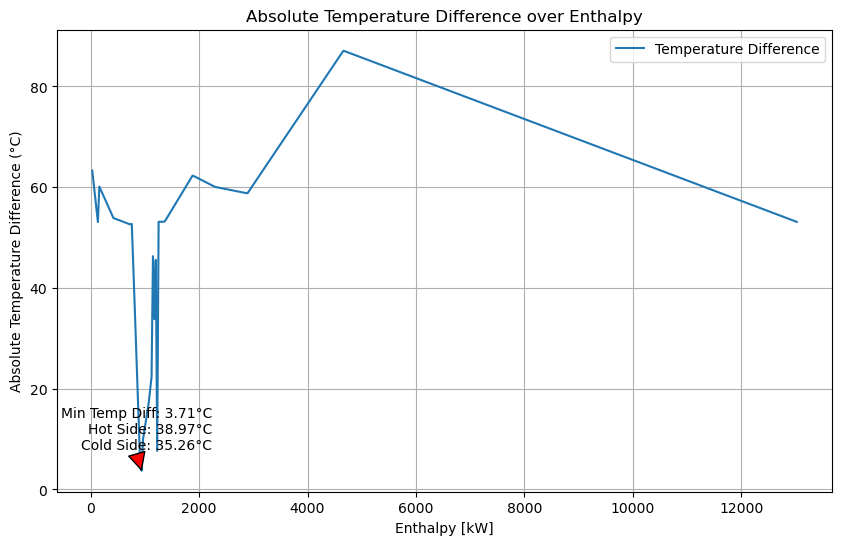

In [19]:
interp_hot, interp_cold = get_interpolated_temps(df_hot, df_cold)

cumulative_utility_min = max(df_hot['Cumulative Utility [kW]'].min(), df_cold['Cumulative Utility [kW]'].min())
cumulative_utility_max = min(df_hot['Cumulative Utility [kW]'].max(), df_cold['Cumulative Utility [kW]'].max())
cumulative_utility_values = np.linspace(cumulative_utility_min, cumulative_utility_max, 500)

temperature_diff = calculate_temperature_diff(interp_hot, interp_cold, cumulative_utility_values)
min_temp_diff, min_temp_diff_utility = find_min_temp_diff(temperature_diff, cumulative_utility_values)
min_temp_hot_side = interp_hot(min_temp_diff_utility)
min_temp_cold_side = interp_cold(min_temp_diff_utility)

plot_temp_diff(cumulative_utility_values, temperature_diff, min_temp_diff, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side)


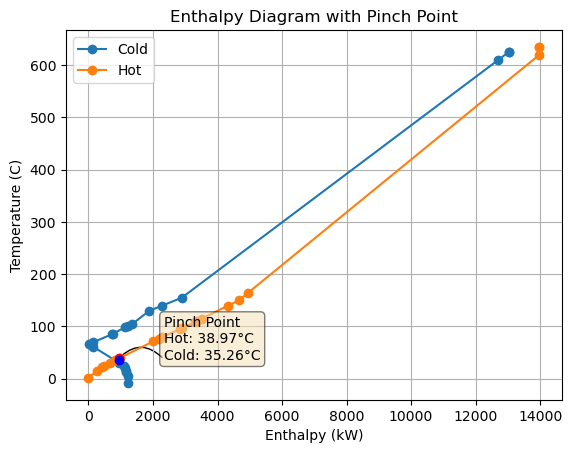

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_enthalpy_diagrams_with_pinch_box(df_hot, df_cold, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side):
    """
    Plot enthalpy diagrams for hot and cold streams with a text box for the pinch point.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    min_temp_diff_utility: The enthalpy at the pinch point.
    min_temp_hot_side: The temperature on the hot side at the pinch point.
    min_temp_cold_side: The temperature on the cold side at the pinch point.
    """
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-o", label='Cold')
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-o", label='Hot')

    # Plotting the pinch point
    plt.scatter(min_temp_diff_utility, min_temp_hot_side, color='red', zorder=5)
    plt.scatter(min_temp_diff_utility, min_temp_cold_side, color='blue', zorder=5)

    # Creating a text box for pinch point information
    textstr = f'Pinch Point\nHot: {min_temp_hot_side:.2f}°C\nCold: {min_temp_cold_side:.2f}°C'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textbox = plt.text(min_temp_diff_utility + 0.1 * (df_hot["Cumulative Utility [kW]"].max() - df_hot["Cumulative Utility [kW]"].min()), 
                       (min_temp_hot_side + min_temp_cold_side) / 2,
                       textstr, bbox=props)

    # Drawing an arrow pointing to the pinch point
    plt.gca().add_patch(mpatches.FancyArrowPatch((textbox.get_position()[0], textbox.get_position()[1]), 
                                                 (min_temp_diff_utility, min_temp_hot_side),
                                                 connectionstyle="arc3,rad=.5", arrowstyle='->', color='black'))

    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram with Pinch Point')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the diagram with the pinch point box
plot_enthalpy_diagrams_with_pinch_box(df_hot, df_cold, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side)
